# การพัฒนา Joy Compiler (เฟส 2)

ในเฟสที่สองนี้ เราจะพัฒนา Joy 1.0 โดยต่อยอดจาก Joy 0.5 เพื่อให้มีฟีเจอร์เพิ่มเติมดังนี้

* รองรับการสร้างนิพจน์ทางคณิตศาสตร์ที่ประกอบด้วยตัวดำเนินการ `+`, `-` (ทั้ง binary และ unary)
* รองรับการจับกลุ่มนิพจน์ด้วยวงเล็บ `()`
* รองรับการสร้างนิพจน์จากตัวดำเนินการเปรียบเทียบ: `>`,`<`,`==`,`!=`,`>=`,`<=`
* รองรับการสร้างนิพจน์ทางตรรกศาสตร์ที่ประกอบด้วยตัวดำเนินการ `&&` (and), `||` (or) และ `!` (not)
* รองรับการควบคุมโปรแกรมโฟลว์ด้วยโครงสร้าง `while` และ `until`

**หมายเหตุ:** นิพจน์ที่ให้ค่าเป็นค่าความจริงจะใช้ค่า 0 และ 1 แทนค่าความจริง "เท็จ" และ "จริง" ตามลำดับ เนื่องจากภาษาจอยมีข้อมูลประเภทเดียวคือจำนวนเต็ม 16 บิต

# ดึงโค้ดจาก Joy 0.5
เราจะพัฒนา Joy 1.0 โดยต่อยอดจาก Joy 0.5 ที่ทำมาก่อนหน้านี้ โดยดาวน์โหลดโน้ตบุ๊คของ Joy 0.5 มาวางไว้บนพื้นที่ดิสก์ของ Colab session ปัจจุบัน ก่อนอื่นเราต้องทราบ file id ของเอกสาร Colab Joy 0.5 ของตนเองก่อน ให้เปิด Colab ของสัปดาห์ที่แล้ว (แม้จะไม่อนุญาตให้แก้ไขเนื่องจากกดส่งไปแล้วก็ไม่เป็นไร) แล้วคัดลอกส่วนที่อยู่ในตำแหน่ง XXXXXXXXXX ออกมาจาก URL ดังแสดง

https://colab.research.google.com/drive/XXXXXXXXXX?authuser=1

จากนั้นนำมาป้อนลงใน `JOY05_COLAB_FILE_ID` ด้านล่าง

In [ ]:
JOY05_COLAB_FILE_ID = '1RWYxAG36YadlhxkxYP9LKnBzFYTDcF6w'

ติดตั้งไลบรารี `PyDrive` เพื่อดาวน์โหลด Colab Notebook จาก Google Drive และโมดูล `comsys_import_ipynb` เพื่อให้อิมพอร์ตโค้ดไพทอนจากโน้ตบุ๊คโดยตรงได้

In [ ]:
%%capture
!pip install PyDrive
!wget -q https://ecourse.cpe.ku.ac.th/courses/comsys/lib/comsys_import_ipynb.py

ใช้ PyDrive2 ดาวน์โหลดเอกสาร Colab ของ Joy 0.5 ในจุดนี้เมื่อ Google แสดงหน้าต่างให้ล็อกอิน ให้เลือกบัญชี @ku.th แล้วกด Allow

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': JOY05_COLAB_FILE_ID})
downloaded.GetContentFile('joy05.ipynb')

ในตอนนี้เอกสาร Colab ของ Joy 1.0 ควรอยู่ในพื้นที่ดิสก์ของ Colab session ปัจจุบัน ภายใต้ชื่อ `joy05.ipynb` เรียบร้อยแล้ว กดดู File Browser ทางด้านซ้ายมือ ควรเห็นไฟล์ชื่อ `joy05.ipynb` อยู่ในนั้น

เรียกใช้ `import_ipynb` และสั่งอิมพอร์ตฟังก์ชันและคลาสที่นิยามไว้ (`draw`, `assemble`, `simulate`, `assemble_and_simulate`, `Joy05` ฯลฯ) มาใช้ในโน้ตบุ๊คนี้เท่าที่จำเป็น

In [ ]:
%%capture
import comsys_import_ipynb
from joy05 import (
    draw, listing, assemble, simulate, assemble_and_simulate,
    gen_load_const, Joy05, TestJoy05, run_test)

รันตัวทดสอบโค้ดของ Joy 0.5 เพื่อให้แน่ใจว่าอิมพอร์ตมาได้ถูกต้อง

In [ ]:
run_test(TestJoy05)

..........
----------------------------------------------------------------------
Ran 10 tests in 0.150s

OK


## นิยาม Pseudo-Instructions สำหรับสแต็ก
การพัฒนาคอมไพเลอร์ในเฟสนี้เน้นไปที่การประมวลผลนิพจน์เป็นหลัก ซึ่งมีการนิยามไวยากรณ์แบบเวียนซ้ำ (กล่าวคือ เราสามารถสร้างนิพจน์ขึ้นมาจากนิพจน์อื่น ๆ ได้) การคำนวณผลลัพธ์ของนิพจน์ลักษณะนี้จำเป็นต้องอาศัยกลไกของสแต็ก (stack) ในการเก็บผลลัพธ์ระหว่างทาง

อย่างไรก็ตามสถาปัตยกรรม Hack นั้นไม่มีฮาร์ดแวร์ที่รองรับการทำงานกับสแต็กอยู่ภายในตัว CPU โดยตรง จึงต้องอาศัยหน่วยความจำปกติมาทำเป็นตัวชี้สแต็ก (stack pointer)
ทั้งนี้ภาษา Hack Assembly ได้กำหนดซิมโบล `SP` เอาไว้สำหรับอ้างถึงหน่วยความจำตำแหน่งที่ 0 เพื่อตั้งใจให้นำมาใช้เป็นตัวชี้สแต็กอยู่แล้ว

เพื่อความสะดวกเราจะจำลองสแต็กขึ้นมาด้วย pseudo-instruction ดังภาพ (ภาพจากหนังสือ The Elements of Computing Systems โดย Noam Nisan และ Shimon Schocken)

![stack.png](https://ecourse.cpe.ku.ac.th/courses/comsys/pics/stack.png)

In [ ]:
def gen_init_stack(addr=0x3fff):
    """
    Generate Hack assembly to initialize stack pointer (SP) to the specified
    address, addr.
    """
    return f'''
        // init stack (SP <- {addr})
        @{addr}
        D=A
        @SP
        M=D
    '''

def gen_push(mem):
    """
    Generate Hack assembly to push the memory location mem to the stack.
    """
    return f'''
        // Push [{mem}]
        @{mem}
        D=M
        @SP
        A=M
        M=D
        @SP
        M=M-1
    '''

def gen_pop(mem=None):
    """
    Generate Hack assembly to pop the value from the top of stack into the
    memory location mem register.  If mem is None, the stack pointer is
    updated without modifying memory.
    """
    if mem:
        return f'''
            // Pop [{mem}]
            @SP
            AM=M+1
            D=M
            @{mem}
            M=D
        '''
    else:
        return f'''
            // Pop
            @SP
            M=M+1
        '''

ทดลองสร้างโค้ดแอสเซมบลี้จากฟังก์ชัน pseudo-instruction ข้างต้น

In [ ]:
asm = '\n'.join([
    gen_init_stack(15),  # กำหนดให้สแต็กเริ่มที่ 15 แทนที่จะเป็น 0x3fff เพื่อให้เห็นได้ง่ายในซิม
    gen_load_const('THIS', 1234),
    gen_push('THIS'),
    gen_pop('THAT'),
])

ใช้ฟังก์ชัน `listing()` จัดระเบียบเอาท์พุทและเก็บลงไฟล์ `asm.out`
เปิดดูไฟล์เอาท์พุทพร้อมกับทดลองรันคำสั่งภาษาเครื่องทีละคำสั่ง หลังจากเสร็จสิ้น pseudo-instruction แต่ละคำสั่งให้สังเกตผลลัพธ์ในหน่วยความจำในตำแหน่งต่าง ๆ ต่อไปนี้
* ตำแหน่ง 0: `R0` หรือ `SP` ใช้เป็นสแต็กพอยเตอร์
* ตำแหน่ง 3: `R3` หรือ `THIS`
* ตำแหน่ง 4: `R4` หรือ `THAT`
* ตำแหน่ง 15,14,...: พื้นที่สแต็กชั่วคราว
* ตำแหน่ง 16,17,...: พื้นที่เก็บตัวแปร

In [ ]:
listing(asm)

// init stack (SP <- 15)
   0: @15
   1: D=A
   2: @SP
   3: M=D
// [THIS] <- 1234
   4: @1234
   5: D=A
   6: @THIS
   7: M=D
// Push [THIS]
   8: @THIS
   9: D=M
  10: @SP
  11: A=M
  12: M=D
  13: @SP
  14: M=M-1
// Pop [THAT]
  15: @SP
  16: AM=M+1
  17: D=M
  18: @THAT
  19: M=D


In [ ]:
assemble_and_simulate(asm)

# Joy 0.6 - Addition Expression

Joy 0.6 รองรับทุกฟีเจอร์ของ Joy 0.5 โดยมีฟีเจอร์เพิ่มเติมดังนี้

---
* รองรับนิพจน์ที่เกิดจากการบวก 2 นิพจน์เข้าด้วยกันในรูป *expr* `+` *expr*
---

เราเริ่มจากการแก้ไขแกรมมาร์ของ Joy 0.5 ให้มาเป็น Joy 0.6 กันก่อน จากกฎ `expr` ของเดิม

```
expr: expr_const
    | expr_id
```

ให้เพิ่มกฎสำหรับนิพจน์บวกลงไปดังนี้
```
expr: expr_const
    | expr_id
    | expr_add
    
expr_add: expr "+" expr
```


In [ ]:
print(Joy05.GRAMMAR) #For copy grammar code from Joy05


        // put Joy05's grammar here
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        expr: expr_const
            | expr_id
        expr_const: NUMBER
        expr_id: ID

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        WS: /[ \t\f\r\n]+/
        %ignore WS
    


In [ ]:
class Joy06(Joy05):

    GRAMMAR = r'''
        // วาง grammar ของ Joy06 ที่แก้ไขเพิ่มเติมจาก Joy05 ไว้ตรงนี้
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_add
        expr_const: NUMBER
        expr_id: ID
        expr_add: expr "+" expr

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        WS: /[ \t\f\r\n]+/
        %ignore WS
    '''

ลองสร้างพาร์ซทรีจากโค้ดตัวอย่างเพื่อนำมาพิจารณาวิเคราะห์โครงสร้าง

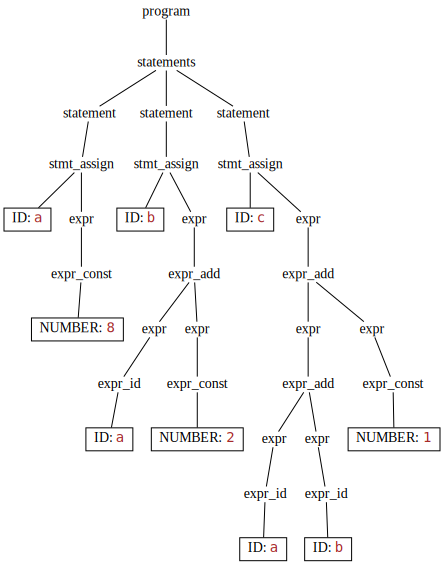

In [ ]:
tree = Joy06().parse('''
    let a = 8;
    let b = a+2;
    let c = a+b+1;
''')
draw(tree)

กระบวนการที่ซับซ้อนที่สุดของการพัฒนาคอมไพเลอร์ในเฟสนี้คือการรองรับการคำนวณค่านิพจน์ซึ่งมีการนิยามแบบรีเคอร์ซีฟ จากพาร์ซทรีข้างต้นจะเห็นว่าโหนด *expr* สามารถงอกลึกลงไปได้เรื่อย ๆ ไม่รู้จบ การสร้างโค้ดให้กับโหนดกลุ่ม *expr* จึงต้องระมัดระวังไม่ให้หน่วยความจำที่เก็บผลลัพธ์ของ *expr* ย่อยระหว่างทางถูกเขียนทับเมื่อประมวลผล *expr* ย่อยตัวอื่น เทคนิคที่นิยมใช้กันคือการเก็บผลลัพธ์ระหว่างทางลงในสแต็ก

เราออกแบบการสร้างโค้ดแอสเซมบลี้เพื่อคำนวณ *expr* ใด ๆ ดังนี้
* ตามข้อตกลงเดิม โหนด *expr* ทุกโหนดจะสร้างโค้ดแอสเซมบลี้ที่เก็บผลลัพธ์ไว้ในหน่วยความจำ THIS (หรือ R3) เสมอ
* โหนด *expr* ใดที่ต้องประมวลผลนิพจน์เชิงซ้อน (เช่น *expr* + *expr*) เมื่อสร้างโค้ดคำนวณ *expr* ตัวซ้ายมือเสร็จแล้ว จะต้องสร้างโค้ดให้เก็บค่า THIS ลงสแต็กก่อนที่จะสร้างโค้ดคำนวณ *expr* ตัวขวามือ ไม่เช่นนั้น THIS จะถูกเขียนทับ เมื่อสร้างโค้ดฝั่งขวาเสร็จแล้วจึงค่อยสร้างโค้ดที่ป็อปค่าออกจากสแต็กมาคำนวณหาผลลัพธ์สุดท้ายอีกทีหนึ่ง

คลาส Joy06 ที่สมบูรณ์แล้วเป็นดังโค้ดด้านล่าง ซึ่งมีการทำงานคร่าว ๆ ดังนี้
* นิยามเมท็อด `__init__()` ขึ้นใหม่ ที่ไปเรียก `__init__()` ของ Joy05 ซึ่งเป็น superclass ก่อน จากนั้นสร้างโค้ดให้มีการกำหนดค่าเริ่มต้นให้ `SP` โดยตั้งค่าดีฟอลท์ไว้ที่ 0x3fff ซึ่งเป็นหน่วยความจำแรมตำแหน่งสุดท้ายก่อนเป็นหน้าจอแสดงผล ค่า `SP` เริ่มต้นนี้อาจปรับให้เป็นค่าน้อย ๆ ได้ระหว่างการพัฒนาเพื่อให้เห็นค่าในสแต็กจากซิมูเลชันได้
* นิยามเมท็อด `expr_add()` เพื่อสร้างโค้ดสำหรับบวกนิพจน์สองตัวเข้าด้วยกันตามขั้นตอนต่อไปนี้
    * เรียก `visit()` สำหรับนิพจน์ด้านซ้าย จะได้ผลลัพธ์เก็บอยู่ใน `THIS` ตามข้อตกลง (ที่เรากำลังต้องทำตาม)
    * นำผลลัพธ์ที่ได้ใน `THIS` มาเก็บไว้ในสแต็ก
    * เรียก `visit()` สำหรับนิพจน์ด้านขวา ได้ผลลัพธ์เก็บอยู่ใน `THIS`
    * ดึงค่าจากสแต็กที่เก็บเอาไว้มาบวกเข้าไปใน `THIS` ทำให้ในตอนนี้ `THIS` จะเก็บผลลัพธ์การบวกได้เรียบร้อยแล้วตามข้อตกลง

In [ ]:
class Joy06(Joy05):

    GRAMMAR = r'''
        // Put your Joy06's grammar here
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_add
        expr_const: NUMBER
        expr_id: ID
        expr_add: expr "+" expr

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        WS: /[ \t\f\r\n]+/
        %ignore WS
    '''

    def __init__(self, init_sp=0x3fff):
        # call Joy05's __init__()
        super().__init__()
        # produce asm code to initialize stack pointer
        self.gen_init_stack(init_sp)

    def gen_init_stack(self, addr=0x3fff):
        """
        Generate Hack assembly to initialize stack pointer (SP) to the specified
        address, addr.
        """
        self._asm.append(f'''
            // init stack (SP <- {addr})
            @{addr}
            D=A
            @SP
            M=D
        ''')

    def gen_push(self, mem):
        """
        Generate Hack assembly to push the memory location mem to the stack.
        """
        self._asm.append(f'''
            // Push [{mem}]
            @{mem}
            D=M
            @SP
            A=M
            M=D
            @SP
            M=M-1
        ''')

    def gen_pop(self, mem=None):
        """
        Generate Hack assembly to pop the value from the top of stack into the
        memory location mem register.  If mem is None, the stack pointer is
        updated without modifying memory.
        """
        if mem:
            self._asm.append(f'''
                // Pop [{mem}]
                @SP
                AM=M+1
                D=M
                @{mem}
                M=D
            ''')
        else:
            self._asm.append(f'''
                // Pop
                @SP
                M=M+1
            ''')

    def expr_add(self, tree):
        [expr1, expr2] = tree.children
        # evaluate expr1; the result should be in THIS
        self.visit(expr1)
        # save THIS to stack before visiting expr2 (THIS will be destroyed!)
        self.gen_push('THIS')
        # evaluate expr2; the result should be in THIS
        self.visit(expr2)
        # pop the previously stored THIS into THAT
        self.gen_pop('THAT')

        # now THIS = expr2, THAT = expr1
        # add THIS to THAT; store result in THIS
        self._asm.append('''
            // [THIS] <- [THAT] + [THIS]
            @THAT
            D=M
            @THIS
            D=D+M
            M=D
        ''')

ทดสอบการเรียกใช้งาน โดยกำหนด SP ให้เริ่มต้นที่ 15 แทนที่จะเป็นส่วนท้ายสุดของหน่วยความจำ เพื่อจะได้เห็นการเปลี่ยนแปลงของสแต็กได้ง่ายในซิมูเลชัน ทดลองเปิดไฟล์ `asm.out` คู่กับการรันซิมูเลชัน

In [ ]:
asm = Joy06(init_sp=15).compile('''
    let a = 8;
    let b = a+2;
    let c = a+b+1;
''')
listing(asm)

// init stack (SP <- 15)
   0: @15
   1: D=A
   2: @SP
   3: M=D
// [THIS] <- 8
   4: @8
   5: D=A
   6: @THIS
   7: M=D
// [.var.a] <- [THIS]
   8: @THIS
   9: D=M
  10: @.var.a
  11: M=D
// [THIS] <- [.var.a]
  12: @.var.a
  13: D=M
  14: @THIS
  15: M=D
// Push [THIS]
  16: @THIS
  17: D=M
  18: @SP
  19: A=M
  20: M=D
  21: @SP
  22: M=M-1
// [THIS] <- 2
  23: @2
  24: D=A
  25: @THIS
  26: M=D
// Pop [THAT]
  27: @SP
  28: AM=M+1
  29: D=M
  30: @THAT
  31: M=D
// [THIS] <- [THAT] + [THIS]
  32: @THAT
  33: D=M
  34: @THIS
  35: D=D+M
  36: M=D
// [.var.b] <- [THIS]
  37: @THIS
  38: D=M
  39: @.var.b
  40: M=D
// [THIS] <- [.var.a]
  41: @.var.a
  42: D=M
  43: @THIS
  44: M=D
// Push [THIS]
  45: @THIS
  46: D=M
  47: @SP
  48: A=M
  49: M=D
  50: @SP
  51: M=M-1
// [THIS] <- [.var.b]
  52: @.var.b
  53: D=M
  54: @THIS
  55: M=D
// Pop [THAT]
  56: @SP
  57: AM=M+1
  58: D=M
  59: @THAT
  60: M=D
// [THIS] <- [THAT] + [THIS]
  61: @THAT
  62: D=M
  63: @THIS
  64: D=D+M
  65: M

In [ ]:
assemble_and_simulate(asm)

## Test case
สคริปต์ทดสอบคลาส Joy06 ด้านล่างต่อยอดมาจากคลาสตัวทดสอบของ Joy05 ดังนั้นสคริปต์ทดสอบตั้งแต่ Joy05 ลงไปถึง ​Joy01 ทั้งหมดจึงถูกดึงมาทดสอบโดยอัตโนมัติ

นอกจากนั้นสคริปต์ทดสอบในแต่ละเคสจะตรวจสอบค่า SP เพื่อให้แน่ใจว่าเมื่อจบโปรแกรมแล้วสแต็กกลับอยู่ในสภาพที่ว่างเปล่า (SP = 0x3fff) เช่นเดิม

เห็นได้ว่ามีการสร้างสคริปต์ทดสอบ `test_expr_avoid_predefined_symbol()` ขึ้นมาทับของเดิมที่เคยนิยามเอาไว้ใน Joy02 เนื่องจากสคริปต์เดิมนั้นมีการตรวจสอบว่าหน่วยความจำตำแหน่งที่ 0 ต้องไม่เปลี่ยนแปลงด้วยคำสั่ง `let R0 = 100;` โดยต้องมีค่าเป็น 0 เมื่อจบโปรแกรม แต่ Joy06 ได้มีการสร้างโค้ดกำหนดค่าเริ่มต้นให้ SP (ตำแหน่ง 0 เช่นกัน) เป็น 0x3fff เอาไว้ที่ต้นโปรแกรม จึงทำให้สคริปต์ทดสอบเดิมรันไม่ผ่าน

In [ ]:
class TestJoy06(TestJoy05):

    JOY_COMPILER = Joy06

    def test_expr_add(self):
        self.compile_and_run('''
            let a = 3+4;
        ''')
        self.assertEqual(self.cpu.ram[16], 7)
        self.assertEqual(self.cpu.ram[0], 0x3fff)  # สแต็กต้องกลับมาว่างเปล่า

run_test(TestJoy06)

...........
----------------------------------------------------------------------
Ran 11 tests in 0.193s

OK


# Joy 0.7 - More Math Expression
Joy 0.7 รองรับทุกฟีเจอร์ของ Joy 0.6 โดยมีฟีเจอร์เพิ่มเติมดังนี้

---
* รองรับการสร้างนิพจน์แบบ binary subtraction ในรูป: *expr* `-` *expr*
* รองรับการสร้างนิพจน์แบบ unary subtraction ในรูป: `-`*expr*
* รองรับการสร้างนิพจน์แบบวงเล็บในรูป: `(`*expr*`)`
---
คำใบ้: นิพจน์แบบวงเล็บนั้นเมื่อสร้างกฎในแกรมมาร์แล้วสามารถใช้งานได้ทันทีโดยไม่ต้องนิยามเมท็อดมาประมวลผลแต่อย่างใด ลองวิเคราะห์ดูว่าเหตุใดจึงทำเช่นนั้นได้

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy07(Joy06):

    GRAMMAR = r'''
        // put your Joy07's grammar here
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_add
            | expr_b_sub
            | expr_u_sub
            | expr_bracket

        expr_const: NUMBER
        expr_id: ID
        expr_add: expr "+" expr
        expr_b_sub: expr "-" expr
        expr_u_sub: "-" expr
        expr_bracket: "(" expr ")"

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        WS: /[ \t\f\r\n]+/
        %ignore WS
    '''

    # add your rule processing methods here
    def expr_b_sub(self, tree):
        [expr1, expr2] = tree.children
        self.visit(expr1)
        self.gen_push('THIS')
        self.visit(expr2)
        self.gen_pop('THAT')
        self._asm.append('''
            // [THIS] <- [THAT] - [THIS]
            @THAT
            D=M
            @THIS
            D=D-M
            M=D
        ''')
    def expr_u_sub(self, tree):
        [expr] = tree.children
        self.visit(expr)
        self.gen_push('THIS')
        #เก็บค่าลบใน THIS
        self._asm.append('''
           //[THIS] <- (-)[THIS]
           @THIS
           M=-M
        ''')
        self.gen_pop()

In [ ]:
tree = Joy07().parse('''
    let a = 8;
    let b = -a;
    let c = 10 + b;
''')
draw(tree)

In [ ]:
asm = Joy07(init_sp=15).compile('''
    let a = 8;
    let b = -a;
''')
#listing(asm)
assemble_and_simulate(asm)

## Test case
รันสคริปต์ทดสอบให้ผ่านทุกเคส สร้างเซลล์เพิ่มเติมหากต้องการทดสอบในซิมูเลเตอร์

In [ ]:
# DO NOT MODIFY

class TestJoy07(TestJoy06):

    JOY_COMPILER = Joy07

    def test_sub(self):
        self.compile_and_run('''
            let a = 8;
            let b = 5;
            let c = a - b;
            let d = (8-2)+(5-3);
        ''')
        self.assertEqual(self.cpu.ram[18], 3)
        self.assertEqual(self.cpu.ram[19], 8)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_negate(self):
        self.compile_and_run('''
            let a = 8;
            let b = -a;
            let c = 10 + b;
        ''')
        self.assertEqual(self.cpu.ram[17], 65536-8)  # b = -8
        self.assertEqual(self.cpu.ram[18], 2)  # c = 2
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_expr_paren(self):
        self.compile_and_run('''
            let a = 3;
            let b = (a+3)+(5+a);
        ''')
        self.assertEqual(self.cpu.ram[16], 3)
        self.assertEqual(self.cpu.ram[17], 14)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

run_test(TestJoy07)

..............
----------------------------------------------------------------------
Ran 14 tests in 0.235s

OK


# Joy 0.8 - Comparison Expression
Joy 0.8 รองรับฟีเจอร์ทั้งหมดของ Joy 0.7 และเพิ่มฟีเจอร์ดังนี้

---
* รองรับนิพจน์เปรียบเทียบในรูป: *expr* *OP* *expr* โดยที่ตัวดำเนินการ *OP* ที่เป็นไปได้คือ `>=`,`<=`,`==`,`>`,`<`,`!=`, ผลลัพธ์จากการเปรียบเทียบจะให้ค่า 1 เมื่อเป็นจริง และ 0 เมื่อเป็นเท็จ
---

คำใบ้: แทนที่จะนิยามกฎแยกเป็น 6 กฎสำหรับตัวดำเนินการแต่ละตัว เราสามารถนิยามเป็นกฎเดียวได้ในรูปแบบด้านล่างได้
```
expr_compare: expr COMPARE_OP expr
```
รวมถึงนิยามโทเค็น `COMPARE_OP` ไว้เป็น
```
COMPARE_OP: ">=" | "<=" | "==" | ">" | "<" | "!="
```

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy08(Joy07):

    GRAMMAR = r'''
        // put your Joy08's grammar here
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_bracket
            | expr_u_sub
            | expr_add
            | expr_b_sub
            | expr_comp

        expr_const: NUMBER
        expr_id: ID
        expr_add: expr "+" expr
        expr_b_sub: expr "-" expr
        expr_u_sub: "-" expr
        expr_bracket: "(" expr ")"
        expr_comp: expr COMPARE_OP expr

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        COMPARE_OP: ">=" | "<=" | "==" | ">" | "<" | "!="
        WS: /[ \t\f\r\n]+/
        %ignore WS
    '''

    # add your rule processing methods here
    def expr_comp(self, tree):
        [expr1, op_token, expr2] = tree.children
        label = self.gen_label_no()

        # evaluate expr1 and push to stack
        self.visit(expr1)
        self.gen_push('THIS')

        # evaluate expr2
        self.visit(expr2)
        self.gen_pop('THAT') # THAT is expr1, THIS is expr2

        # Compare THAT and THIS
        self._asm.append('''
            // D <- [THAT] - [THIS]
            @THAT
            D=M
            @THIS
            D=D-M
        ''')
        # Choose an op_token
        match(op_token):
          case ">=":
            self._asm.append(f'''
              // D >= 0 ?
              @.label_true.{label}
              D;JGE
            ''')
          case "<=":
            self._asm.append(f'''
              // D <= 0 ?
              @.label_true.{label}
              D;JLE
            ''')
          case "==":
            self._asm.append(f'''
              // D == 0 ?
              @.label_true.{label}
              D;JEQ
            ''')
          case ">":
            self._asm.append(f'''
              // D > 0 ?
              @.label_true.{label}
              D;JGT
            ''')
          case "<":
            self._asm.append(f'''
              // D < 0 ?
              @.label_true.{label}
              D;JLT
            ''')
          case "!=":
            self._asm.append(f'''
              // D != 0 ?
              @.label_true.{label}
              D;JNE
            ''')
        # If it's false return 0 then go to end
        self._asm.append(f'''
            // False set [THIS] = 0 and go to end
            @0
            D=A
            @THIS
            M=D
            @.label_end.{label}
            0;JMP
        ''')
        # If it's true return 1 then go to end
        self._asm.append(f'''
            // True set [THIS] = 1 and go to end
            (.label_true.{label})
            @1
            D=A
            @THIS
            M=D
            @.label_end.{label}
            0;JMP
            (.label_end.{label})
        ''')


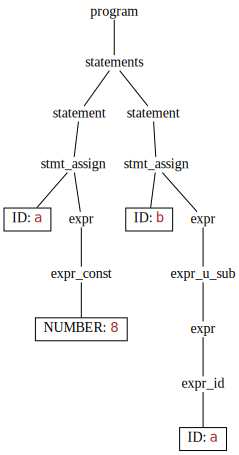

In [ ]:
tree = Joy08().parse('''
    let a = 8;
    let b = -a;
''')
draw(tree)

In [ ]:
asm = Joy08(init_sp=15).compile('''
    let a = 8;
    let b = -a;
    let c = a>=b;
''')
#listing(asm)
assemble_and_simulate(asm)

## Test case
รันสคริปต์ทดสอบให้ผ่านทุกเคส สร้างเซลล์เพิ่มเติมหากต้องการทดสอบในซิมูเลเตอร์

In [ ]:
# DO NOT MODIFY

class TestJoy08(TestJoy07):

    JOY_COMPILER = Joy08

    def base_test_compare(self, comp_op, comp_func):
        template = '''
            let a = {a};
            let b = {b};
            let result1 = (a {op} b);
            let result2 = (a {op} b);
        '''
        data = [(1,2), (2,1), (2,2), (-2,1), (-1,2)]
        for a, b in data:
            result = 1 if comp_func(a, b) else 0
            self.compile_and_run(template.format(a=a, b=b, op=comp_op))
            self.assertEqual(self.cpu.ram[16], a%65536)
            self.assertEqual(self.cpu.ram[17], b%65536)
            self.assertEqual(self.cpu.ram[18], result)
            self.assertEqual(self.cpu.ram[19], result)
            self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_comp_gt(self):
        self.base_test_compare('>',lambda a, b: a>b)

    def test_comp_lt(self):
        self.base_test_compare('<',lambda a, b: a<b)

    def test_comp_eq(self):
        self.base_test_compare('==',lambda a, b: a==b)

    def test_comp_neq(self):
        self.base_test_compare('!=',lambda a, b: a!=b)

    def test_comp_gte(self):
        self.base_test_compare('>=',lambda a, b: a>=b)

    def test_comp_lte(self):
        self.base_test_compare('<=',lambda a, b: a<=b)

run_test(TestJoy08)

....................
----------------------------------------------------------------------
Ran 20 tests in 1.039s

OK


# Joy 0.9 - Logical Expression

Joy 0.9 รองรับฟีเจอร์ทั้งหมดของ Joy 0.8 และเพิ่มฟีเจอร์ดังนี้

---
* รองรับนิพจน์ทางตรรกศาสตร์แบบ and ในรูป: *expr* `&&` *expr*
* รองรับนิพจน์ทางตรรกศาสตร์แบบ or ในรูป: *expr* `||` *expr*
* รองรับนิพจน์ทางตรรกศาสตร์แบบ not ในรูป: `!` *expr*
---

โดยให้ตีความว่าค่า *expr* ที่เท่ากับศูนย์คือค่า<u>เท็จ</u> และไม่เท่ากับศูนย์คือค่า<u>จริง</u> ผลลัพธ์ของนิพจน์ทางตรรกศาสตร์ทั้งสามแบบข้างต้นให้ค่าเป็น 0 หรือ 1 เสมอ ตัวอย่างเช่น
* `2 && 0` ให้ผลลัพธ์เป็น 0
* `2 && 1` ให้ผลลัพธ์เป็น 1
* `2 || 0` ให้ผลลัพธ์เป็น 1
* `!0` ให้ผลลัพธ์เป็น 1
* `!50` ให้ผลลัพธ์เป็น 0


In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy09(Joy08):

    GRAMMAR = r'''
        // put your Joy09's grammar here
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_bracket
            | expr_u_sub
            | expr_b_sub
            | expr_add
            | expr_comp
            | expr_logic

        expr_const: NUMBER
        expr_id: ID
        expr_add: expr "+" expr
        expr_b_sub: expr "-" expr
        expr_u_sub: "-" expr
        expr_bracket: "(" expr ")"
        expr_comp: expr COMPARE_OP expr
        expr_logic: expr LOGIC_BIN_OP expr
                  | LOGIC_UN_OP expr

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        COMPARE_OP: ">=" | "<=" | "==" | ">" | "<" | "!="
        LOGIC_BIN_OP: "&&" | "||"
        LOGIC_UN_OP: "!"
        WS: /[ \t\f\r\n]+/
        %ignore WS
    '''

    # add your rule processing methods here

    def expr_logic(self, tree):
        if len(tree.children) == 3: # Binary logic op
            [expr1, op_token, expr2] = tree.children
            label = self.gen_label_no()

            # evaluate expr1 and push to stack
            self.visit(expr1)
            self.gen_push('THIS')

            # evaluate expr2
            self.visit(expr2)
            self.gen_pop('THAT') # THAT is expr1, THIS is expr2

            self._asm.append('''
                // D <- [THAT]
                @THAT
                D=M
            ''')
            match(op_token):
                case "&&":
                    self._asm.append(f'''
                        // If THAT is 0, result is 0
                        @.label_false.{label}
                        D;JEQ
                        // If THAT is not 0, check THIS
                        @THIS
                        D=M
                        // If THIS is 0, result is 0
                        @.label_false.{label}
                        D;JEQ
                        // Both are non-zero, result is 1
                        @1
                        D=A
                        @THIS
                        M=D
                        @.label_end.{label}
                        0;JMP
                    ''')
                case "||":
                    self._asm.append(f'''
                        // If THAT is non-zero, result is 1
                        @.label_true.{label}
                        D;JNE
                        // If THAT is 0, check THIS
                        @THIS
                        D=M
                        // If THIS is non-zero, result is 1
                        @.label_true.{label}
                        D;JNE
                        // Both are 0, result is 0
                        @0
                        D=A
                        @THIS
                        M=D
                        @.label_end.{label}
                        0;JMP
                    ''')

            # False case: result is 0
            self._asm.append(f'''
                (.label_false.{label})
                @0
                D=A
                @THIS
                M=D
                @.label_end.{label}
                0;JMP
            ''')
            # True case: result is 1
            self._asm.append(f'''
                (.label_true.{label})
                @1
                D=A
                @THIS
                M=D
                (.label_end.{label})
            ''')

        elif len(tree.children) == 2: # Unary logic op (NOT)
            [op_token, expr] = tree.children
            label = self.gen_label_no()

            # evaluate expr
            self.visit(expr) # result in THIS

            # Logic NOT operation (0 is False, non-zero is True)
            self._asm.append('''
                // D <- [THIS]
                @THIS
                D=M
            ''')
            self._asm.append(f'''
                // If THIS is 0, result is 1
                @.label_true.{label}
                D;JEQ
                // If THIS is non-zero, result is 0
                @0
                D=A
                @THIS
                M=D
                @.label_end.{label}
                0;JMP
            ''')
            # True case: result is 1
            self._asm.append(f'''
                (.label_true.{label})
                @1
                D=A
                @THIS
                M=D
                (.label_end.{label})
            ''')

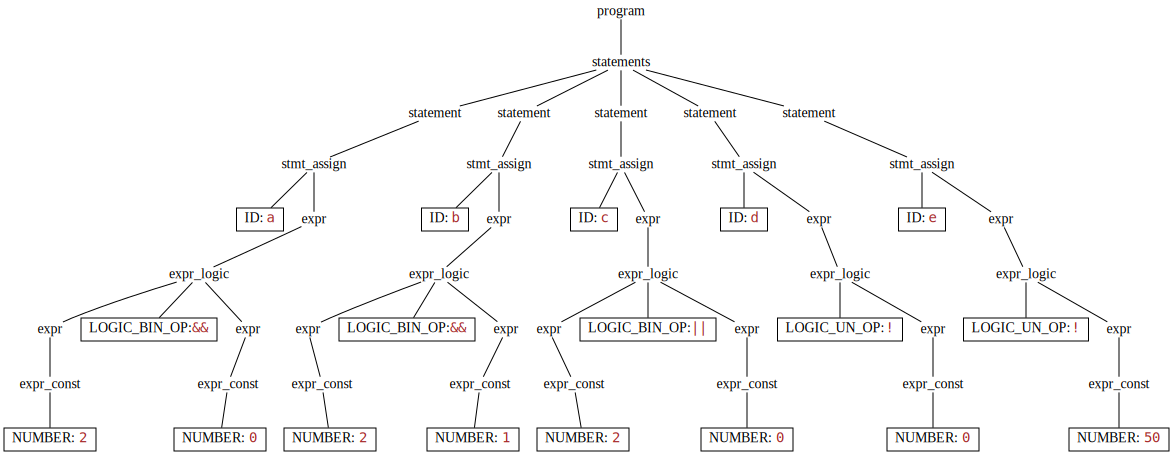

In [ ]:
tree = Joy09().parse('''
    let a = 2 && 0;
    let b = 2 && 1;
    let c = 2 || 0;
    let d = !0;
    let e = !50;
''')
draw(tree)

## Test case
รันสคริปต์ทดสอบให้ผ่านทุกเคส สร้างเซลล์เพิ่มเติมหากต้องการทดสอบในซิมูเลเตอร์

In [ ]:
# DO NOT MODIFY

class TestJoy09(TestJoy08):

    JOY_COMPILER = Joy09

    def base_test_and_or(self, bool_op, bool_func):
        template = '''
            let a = {a};
            let b = {b};
            let result1 = a {op} b;
            let result2 = a {op} b;
        '''
        data = [(x, y) for x in [0, 1, 2] for y in [0, 1, 2]]
        for a, b in data:
            result = 1 if bool_func(a, b) else 0
            self.compile_and_run(template.format(a=a, b=b, op=bool_op))
            self.assertEqual(self.cpu.ram[16], a)
            self.assertEqual(self.cpu.ram[17], b)
            self.assertEqual(self.cpu.ram[18], result)
            self.assertEqual(self.cpu.ram[19], result)
            self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_and(self):
        self.base_test_and_or("&&", lambda a, b: a and b)

    def test_or(self):
        self.base_test_and_or("||", lambda a, b: a or b)

    def test_not(self):
        template = '''
            let a = {a};
            let result1 = !a;
            let result2 = !a;
        '''
        data = [0, 1, 2]
        for a in data:
            self.compile_and_run(template.format(a=a))
            self.assertEqual(self.cpu.ram[16], a)
            self.assertEqual(self.cpu.ram[17], not a)
            self.assertEqual(self.cpu.ram[18], not a)
            self.assertEqual(self.cpu.ram[0], 0x3fff)

run_test(TestJoy09)

.......................
----------------------------------------------------------------------
Ran 23 tests in 1.631s

OK


# Joy 1.0 - Loop Construct
Joy 1.0 รองรับฟีเจอร์ทั้งหมดของ Joy 0.9 และเพิ่มฟีเจอร์ดังนี้

---
* รองรับโครงสร้าง while ในรูปแบบ: `while` *expr* `{` *statements* `}` ซึ่ง *statements* จะถูกเรียกทำงานไปเรื่อย ๆ <u>ตราบเท่าที่</u> *expr* มีค่าไม่เท่ากับศูนย์
* รองรับโครงสร้าง until ในรูปแบบ: `until` *expr* `{` *statements* `}` ซึ่ง *statements* จะถูกเรียกทำงานไปเรื่อย ๆ <u>จนกระทั่ง</u> *expr* มีค่าไม่เท่ากับศูนย์
---

คำใบ้: แนะนำให้เขียนโฟลว์ชาร์ทของโครงสร้าง while และ until ออกมาดูก่อน จะช่วยให้เห็นภาพชัดเจนขึ้นว่าควรวางลาเบลสำหรับกระโดดที่จุดใดบ้าง

In [ ]:
# DO NOT ERASE THIS CELL - to be graded

class Joy10(Joy09):

    GRAMMAR = r'''
        // put your Joy10's grammar here
        program: statements
        statements: statement*
        statement: stmt_assign
                 | stmt_if
                 | stmt_if_else
                 | stmt_while
                 | stmt_until
        stmt_assign: "let" ID "=" expr ";"
        stmt_if: "if" expr "{" statements "}"
        stmt_if_else: "if" expr "{" statements "}" "else" "{" statements "}"
        stmt_while: "while" expr "{" statements "}"
        stmt_until: "until" expr "{" statements "}"
        expr: expr_const
            | expr_id
            | expr_add
            | expr_b_sub
            | expr_u_sub
            | expr_bracket
            | expr_comp
            | expr_logic
        expr_const: NUMBER
        expr_id: ID
        expr_add: expr "+" expr
        expr_b_sub: expr "-" expr
        expr_u_sub: "-" expr
        expr_bracket: "(" expr ")"
        expr_comp: expr COMPARE_OP expr
        expr_logic: expr LOGIC_BIN_OP expr
                  | LOGIC_UN_OP expr

        ID: /[_A-Za-z][_0-9A-Za-z]*/
        NUMBER: /-?[0-9]+/
        COMPARE_OP: ">=" | "<=" | "==" | ">" | "<" | "!="
        LOGIC_BIN_OP: "&&" | "||"
        LOGIC_UN_OP: "!"
        WS: /[ \t\f\r\n]+/
        %ignore WS
    '''

    # add your rule processing methods here
    def stmt_while(self, tree):
        [expr, while_body] = tree.children
        label = self.gen_label_no()

        self._asm.append(f'''
            // while loop start
            (.while_loop.{label})
        ''')
        # evaluate condition
        self.visit(expr)

       # checking condition
        self._asm.append(f'''
            // check condition
            @THIS
            D=M
            @.end_while.{label}
            D;JEQ   // if condition == 0 (false), exit loop
            // run while body
        ''')

        # loop body
        self.visit(while_body)

        # jump back to loop start
        self._asm.append(f'''
            // jump back to condition
            @.while_loop.{label}
            0;JMP
        ''')

        # end of while
        self._asm.append(f'''
            // while loop end
            (.end_while.{label})
        ''')



    def stmt_until(self, tree):
        [expr, until_body] = tree.children
        label = self.gen_label_no()

        self._asm.append(f'''
            // until loop start
            (.until_loop.{label})
        ''')
        # evaluate condition
        self.visit(expr)

       # checking condition
        self._asm.append(f'''
            // check condition
            @THIS
            D=M
            @.end_until.{label}
            D;JNE   // if condition != 0 (true), exit loop
            // run until body
        ''')

        # loop body
        self.visit(until_body)

        # jump back to loop start
        self._asm.append(f'''
            // jump back to condition
            @.until_loop.{label}
            0;JMP
        ''')

        # end of while
        self._asm.append(f'''
            // until loop end
            (.end_until.{label})
        ''')



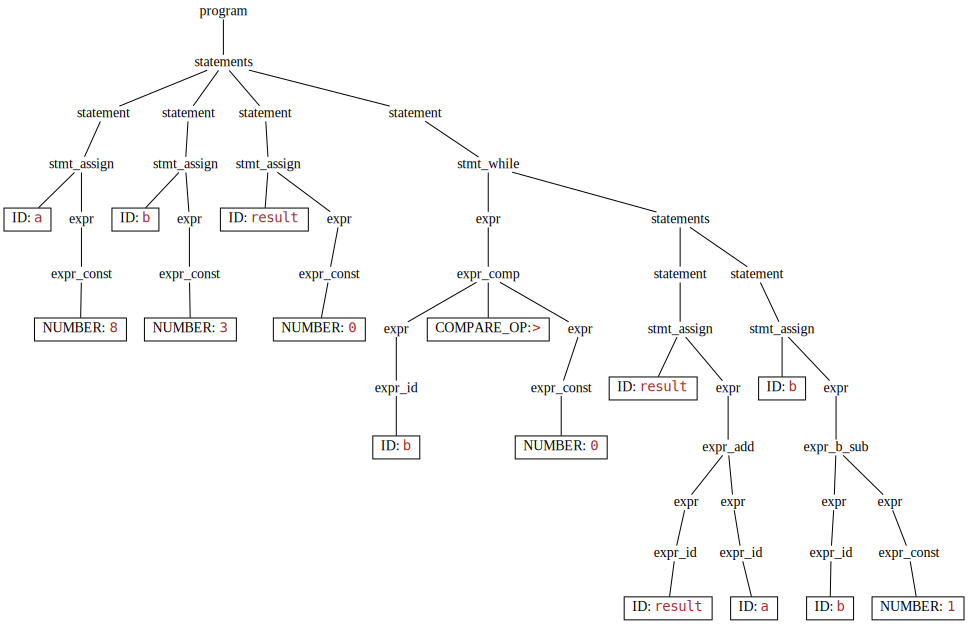

In [ ]:
tree = Joy10().parse('''
    let a = 8;
            let b = 3;
            let result = 0;
            while b > 0 {
                let result = result + a;
                let b = b - 1;
            }
''')
draw(tree)

In [ ]:
asm = Joy10(init_sp=15).compile('''
    let a = 8;
    let b = 3;
    let result = 0;
    while b > 0 {
        let result = result + a;
        let b = b - 1;
    }
''')
#listing(asm)
assemble_and_simulate(asm)

In [ ]:
asm = Joy10(init_sp=15).compile('''
    let a = 8;
    let b = 3;
    let result = 0;
    until b == 0 {
        let result = result + a;
        let b = b - 1;
    }
''')
#listing(asm)
assemble_and_simulate(asm)

## Test case
รันสคริปต์ทดสอบให้ผ่านทุกเคส สร้างเซลล์เพิ่มเติมหากต้องการทดสอบในซิมูเลเตอร์

In [ ]:
# DO NOT MODIFY

class TestJoy10(TestJoy09):

    JOY_COMPILER = Joy10

    def test_while(self):
        self.compile_and_run('''
            let a = 8;
            let b = 3;
            let result = 0;
            while b > 0 {
                let result = result + a;
                let b = b - 1;
            }
        ''')
        self.assertEqual(self.cpu.ram[18], 24)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_until(self):
        self.compile_and_run('''
            let a = 8;
            let b = 3;
            let result = 0;
            until b == 0 {
                let result = result + a;
                let b = b - 1;
            }
        ''')
        self.assertEqual(self.cpu.ram[18], 24)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

    def test_nested_loop(self):
        # compute a**b
        self.compile_and_run('''
            let result = 0;
            let a = 5;
            let b = 4;
            let ta = a;
            while b > 1 {
                let result = 0;
                let count = a;
                while count > 0 {
                    let result = result + ta;
                    let count = count - 1;
                }
                let ta = result;
                let b = b - 1;
            }
        ''')
        self.assertEqual(self.cpu.ram[16], 5**4)
        self.assertEqual(self.cpu.ram[0], 0x3fff)

run_test(TestJoy10)

..........................
----------------------------------------------------------------------
Ran 26 tests in 1.520s

OK
